+ [x] 데이터 불러오기(MySQL)
+ [x] tokenizer(KoNLPy)
+ [x] EDA
+ [ ] Modeling/결과비교
  + [ ] Topic(sickit-learn)
  + [ ] LAD
  + [ ] RNN
  + [ ] 1D-CNN
  

In [1]:
import pandas as pd
import numpy as np

import os
import pymysql
import matplotlib.pyplot as plt
from skimage import io
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)

from konlpy.tag import Okt
okt = Okt("C:/Program Files/Java/jdk-12.0.1/bin/server/jvm.dll")
okt = Okt()

In [2]:
# '201103_train_data_LIVECOMM.xls'

### 데이터 불러오기

In [216]:
###############
# 2.자료 추출
#####

# DB연결
conn = pymysql.connect(host = '10.223.7.4', user ='MAEIL_CS', password = "Maeil01!@", database='MAEIL_CS')

# cursor 설정
cursor = conn.cursor(pymysql.cursors.DictCursor)

#자료 불러오기 : 전날 부정리뷰 겟수

sql= '''select (SELECT CODE_NM FROM JT_CODE B WHERE A.COMPANY_CODE = B.CODE AND B.CODE_GRP_ID = 'DEALER_ID') as 수집체널 
        , GROUP_CONCAT( distinct (SELECT concat(  '(', code, ') ' , code_nm) FROM JT_CODE B WHERE A.PRODUCT_CODE = B.CODE AND B.CODE_GRP_ID = 'PRODUCT') SEPARATOR ', ') as "(code)구매제품"
        , A.WRITER as "작성자ID" , A.CONTENTS as 내용 , A.WRITE_DT as 작성일자 , A.GRADE as "평점(5점 만점)", PRODUCT_NO as "상품번호(네이버)"
        FROM MAEIL_REVIEW A
        where A.GRADE in (1,2)
        and PRODUCT_CODE not like 'G_%'
        group by A.COMPANY_CODE, A.WRITER, A.CONTENTS, A.WRITE_DT, A.GRADE, A.PRODUCT_NO
        order by A.COMPANY_CODE, A.GRADE desc
        '''

cursor.execute(sql)
result1 = cursor.fetchall()
result1 = pd.DataFrame(result1)


sql= '''select (SELECT CODE_NM FROM JT_CODE B WHERE A.COMPANY_CODE = B.CODE AND B.CODE_GRP_ID = 'DEALER_ID') as 수집체널 
        , GROUP_CONCAT( distinct (SELECT concat(  '(', code, ') ' , code_nm) FROM JT_CODE B WHERE A.PRODUCT_CODE = B.CODE AND B.CODE_GRP_ID = 'PRODUCT') SEPARATOR ', ') as "(code)구매제품"
        , A.WRITER as "작성자ID" , A.CONTENTS as 내용 , A.WRITE_DT as 작성일자 , A.GRADE as "평점(5점 만점)", PRODUCT_NO as "상품번호(네이버)"
        FROM MAEIL_REVIEW A
        where A.GRADE in (4,5)
        and WRITE_DT between DATE_SUB(CURDATE(), INTERVAL 1 DAY) and (CURDATE())
        and PRODUCT_CODE not like 'G_%'
        group by A.COMPANY_CODE, A.WRITER, A.CONTENTS, A.WRITE_DT, A.GRADE, A.PRODUCT_NO
        order by A.COMPANY_CODE, A.GRADE desc
        '''

cursor.execute(sql)
result2 = cursor.fetchall()
result2 = pd.DataFrame(result2)

In [228]:
result0 = pd.concat([result1, result2])
result0 = result0[['(code)구매제품', '내용', '평점(5점 만점)']]

In [229]:
result0['평점(5점 만점)'] = result0['평점(5점 만점)'].astype(int)
result0['평점(5점 만점)'] = np.select([result0['평점(5점 만점)'] >= 3], [1], default=0)

In [230]:
result0.tail()

,(code)구매제품,내용,평점(5점 만점)
1962,(106111) 셀렉스 코어프로틴 [ 스틱 ] [ 19g x 10 ],이런 이벤트 좋아요 동네방네 소문내고 있어요ㅋ 유통기한도 길어서 좋네요,5
1963,(106526) 밀크세라마이드 체험키트 [ 7포 ] [ NEW ],약간 시큼한 분유맛 맛있어요. 분유 훔쳐먹던 생각도나고ㅎㅎ 맛있는간식이 되겠어요,5
1964,(106012) 셀렉스 슬림 25 [ 말차 ] [ 36g x 10 ],맛있는 녹차라떼 맛이에요 세일해서 득템하네요 세일자주해주세요 맛있어요,5
1965,(106011) 셀렉스 슬림 25 [ 그레인 ] [ 36g x 10 ],맛있네요 다이어트아니어도 단백질보충용으로도 휼륭해요 엄마도 좋아하세요 맛있다고,5
1966,(106018) 셀렉스 코어프로틴플러스 [ 304g ],좋 습 니 다\n영양가도 많고 \n유효기간도1년 이네요\n닭가슴살과 같이 먹으면 ...,4


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


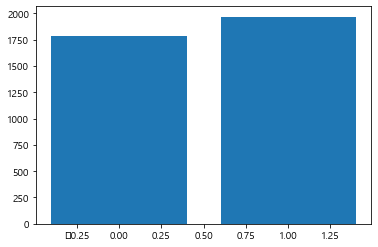

In [234]:
plt.bar(result0.groupby(['평점(5점 만점)']).count().index, result0.groupby(['평점(5점 만점)']).count()['내용'])
plt.show()

###  tokenizer(KoNLPy)

In [7]:
from gensim import corpora
import gensim

In [235]:
result0.tail(2)

,(code)구매제품,내용,평점(5점 만점)
1965,(106011) 셀렉스 슬림 25 [ 그레인 ] [ 36g x 10 ],맛있네요 다이어트아니어도 단백질보충용으로도 휼륭해요 엄마도 좋아하세요 맛있다고,1
1966,(106018) 셀렉스 코어프로틴플러스 [ 304g ],좋 습 니 다\n영양가도 많고 \n유효기간도1년 이네요\n닭가슴살과 같이 먹으면 ...,1


In [236]:
################
#한글 토큰화
#####

# 1차 가공 : koNLpy to token
def tokenize(doc):
    result = [t for t in okt.pos(doc, norm=True, stem=True)] # ex '더빙/Norm', '나다/Verb'
    return result 

token_data1 = [tokenize(row) for row in result0['내용']]  

In [237]:
token_data1[2]

[('맛', 'Noun'),
 ('이', 'Josa'),
 ('생각', 'Noun'),
 ('보다', 'Josa'),
 ('물', 'Noun'),
 ('에', 'Josa'),
 ('타다', 'Verb'),
 ('듯', 'Noun'),
 ('해', 'Noun'),
 ('요', 'Josa'),
 ('.', 'Punctuation'),
 ('\r\n', 'Foreign'),
 ('배송', 'Noun'),
 ('괜찮다', 'Adjective'),
 ('!', 'Punctuation')]

In [238]:
token_data2 = []
for i in range(0, len(token_data1)):
    r = []
    for word in token_data1[i]:
        if not word[1] in ["Josa", "Punctuation", "Foreign", "Suffix", "Eomi"]:
            r.append(word[0])
    token_data2.append(r)

In [239]:
i =51 
print(token_data1[i])
print('')
print(token_data2[i])

[('가성', 'Noun'), ('비', 'Noun'), ('떨어지다', 'Verb'), ('200', 'Number'), ('mm', 'Alpha'), ('48', 'Number'), ('팩', 'Noun'), ('더', 'Noun'), ('쓸모', 'Noun'), ('가', 'Josa'), ('있다', 'Adjective'), ('\r\n', 'Foreign'), ('배송', 'Noun'), ('별로', 'Noun'), ('예요', 'Josa'), ('!', 'Punctuation')]

['가성', '비', '떨어지다', '200', 'mm', '48', '팩', '더', '쓸모', '있다', '배송', '별로']


In [264]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', '때', '더', '올', '지', '께',
             '안','다','요','것','로','무','머','하고','늘','했어요','나','고', '해', '에서', '입니다','을','저','매', '일','오', '씩'
             '아주', '인', '랑']

X_train = []
for sentence in token_data2:
    temp_X = [word for word in sentence if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [241]:
# data_trim2.str.startswith('/Josa')

### Modeling 1 :  Topic(sickit-learn)

+ mulit-model에 대한 검증(비교)을 할 것인가?

In [ ]:
def make_topictable_per_doc(ldamodel, corpus):
    topic_table = pd.DataFrame()
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list            
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)

        # 모든 문서에 대해서 각각 아래를 수행
        for j, (topic_num, prop_topic) in enumerate(doc): #  몇 번 토픽인지와 비중을 나눠서 저장한다.
            if j == 0:  # 정렬을 한 상태이므로 가장 앞에 있는 것이 가장 비중이 높은 토픽
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)
            else:
                break
    return(topic_table)

In [ ]:
# 사전 및 단어집 만들기
dictionary = corpora.Dictionary(X_train)
corpus = [dictionary.doc2bow(text) for text in X_train]

# 토픽 겟수 설정 : 20개
NUM_TOPICS = 20 

# LAD 모델링
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=5)

In [ ]:
# 토픽 현황 확인
for topic in topics:
    print(topic)

In [ ]:
df_item = pd.DataFrame()
df_item['가장 비중이 높은 토픽'] = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
df_item['Category'] = ['재구매','맛','맛','배송','유통기한','맛','맛','맛','배송','맛','맛','맛','맛','재구매','맛','맛','맛','재구매','akt','배송']

In [ ]:
# model save
temp_file = datapath("model")
ldamodel.save(temp_file)

# model load
# ldamodel = LdaModel.load(temp_file)

In [ ]:
# df_item

In [ ]:
# data frame 만들기
topictable = make_topictable_per_doc(ldamodel, corpus)
topictable = topictable.reset_index() # 문서 번호을 의미하는 열(column)로 사용하기 위해서 인덱스 열을 하나 더 만든다.
topictable.columns = ['문서 번호', '가장 비중이 높은 토픽', '가장 높은 토픽의 비중', '각 토픽의 비중']

topictable['(code)구매제품'] = list(result0['(code)구매제품'])
topictable['내용'] = list(result0['내용'])

In [ ]:
topictable2 = pd.merge(topictable, df_item, on ='가장 비중이 높은 토픽')

In [ ]:
topictable2.tail()

In [ ]:
plt.bar(topictable.groupby(['가장 비중이 높은 토픽']).count().index, topictable.groupby(['가장 비중이 높은 토픽']).count()['내용'])
plt.show()

In [ ]:
plt.bar(topictable2.groupby(['Category']).count().index, topictable2.groupby(['Category']).count()['내용'])
plt.show()

In [ ]:
# Excel 자료 저장 v2
writer = pd.ExcelWriter('./210419_NLP_LDA.xlsx')
topictable.to_excel(writer, 'Sheet1')
writer.save()

### Modeling 2 :  RNN
+ categorical transf
+ test/train split
+ tokenizer
+ pedding
+ model
+ optimizer/loss 


In [266]:
result0.head()

,(code)구매제품,내용,평점(5점 만점)
0,(105645) 멸균 아몬드브리즈 [ 프로틴 ] [ 190ml ],아이들 먹기는 싱겁고 걍 어른용이 어울리네요\r\n배송 아주 좋아요!,0
1,(105645) 멸균 아몬드브리즈 [ 프로틴 ] [ 190ml ],더 비싸게 파는데 톡딜의 의미가 없죠..\r\n배송 괜찮아요!,0
2,(105645) 멸균 아몬드브리즈 [ 프로틴 ] [ 190ml ],맛이 생각보다 물에 탄 듯 해요.\r\n배송 괜찮아요!,0
3,(106141) 멸균 상하목장 유기농 우유 [ 125ML ] [ NEW 콤비블록 ],이렇게 까지 작을 줄 몰랐어요ㅋㅋㅋㅋ 아기들 먹는 우유인것 같아요! 맛은 분유맛 나...,0
4,(106141) 멸균 상하목장 유기농 우유 [ 125ML ] [ NEW 콤비블록 ],일반 멸균 용량이 아니라 미니 사이즈네요 용량 확인안한 구매실수....\r\n배송 ...,0


In [267]:
# categorical transf
topictable2 = pd.DataFrame()
topictable2["lable"] = result0["평점(5점 만점)"].astype('category').cat.codes
topictable2['tokenized'] = X_train

In [268]:
topictable2.head(2)

,lable,tokenized
0,0,"[아이, 먹기, 싱겁다, 어른, 용이, 어울리다, 배송, 아주, 좋다]"
1,0,"[비싸다, 팔다, 톡딜, 의미, 없다, 배송, 괜찮다]"


In [269]:
# test/train split

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(topictable2, test_size = 0.25, random_state = 42)

X_train = train_data['tokenized'].values
y_train = train_data['lable'].values
X_test= test_data['tokenized'].values
y_test = test_data['lable'].values

In [270]:
# tokenizer(정수 인코딩)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [271]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 3801
등장 빈도가 1번 이하인 희귀 단어의 수: 1792
단어 집합에서 희귀 단어의 비율: 47.14548802946593
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.5735257526747946


In [272]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
vocab_size = total_cnt - rare_cnt + 2
# print('단어 집합의 크기 :',vocab_size)

In [273]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [274]:
X_train[10]

[598, 29, 2, 1, 3]

In [275]:
# pedding

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [278]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 93.81003201707577


In [279]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [280]:
X_train[100]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,   27, 1204,  241,   93,   10,    2])

In [295]:
# LSTM

from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#레이어 구성
model = Sequential()
model.add(Embedding(vocab_size, max_len))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))


# hyper parameter 설정
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# loss 설정
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['acc'])

In [296]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 30)          60330     
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               81408     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 141,867
Trainable params: 141,867
Non-trainable params: 0
_________________________________________________________________


In [297]:
history = model.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 0.6445 - acc: 0.6561
Epoch 00001: val_acc improved from -inf to 0.78330, saving model to best_model.h5
38/38 [==============================] - 2s 51ms/step - loss: 0.6445 - acc: 0.6561 - val_loss: 0.5348 - val_acc: 0.7833
Epoch 2/100
37/38 [============================>.] - ETA: 0s - loss: 0.4387 - acc: 0.8225
Epoch 00002: val_acc improved from 0.78330 to 0.83126, saving model to best_model.h5
38/38 [==============================] - 1s 37ms/step - loss: 0.4353 - acc: 0.8243 - val_loss: 0.3885 - val_acc: 0.8313
Epoch 3/100
37/38 [============================>.] - ETA: 0s - loss: 0.2952 - acc: 0.8986
Epoch 00003: val_acc improved from 0.83126 to 0.86679, saving model to best_model.h5
38/38 [==============================] - 1s 36ms/step - loss: 0.2953 - acc: 0.8986 - val_loss: 0.3425 - val_acc: 0.8668
Epoch 4/100
37/38 [============================>.] - ETA: 0s - loss: 0.2519 - acc: 0.9108
Epoch 00004: val_acc improve

In [294]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

30/30 [==============================] - 0s 11ms/step - loss: 0.3396 - acc: 0.8902

 테스트 정확도: 0.8902


KeyError: 'acc'

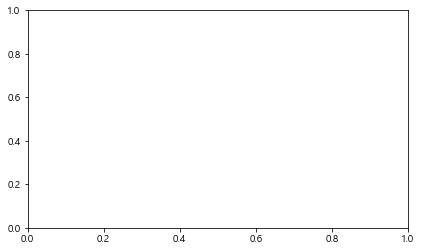

In [308]:
# 5. model evalustion : v1
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train_accuracy', 'test_accuracy'], loc='lower right')

plt.subplot(1,2,2)
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_loss', 'test_loss'], loc='upper right')
plt.show()

In [302]:
import tensorflow as tf

#레이어 구성
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(30,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

#학습 프로세스 설정
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy', metrics=['acc'])

# model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['acc'])

# hyper parameter 설정
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [303]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 64)                1984      
_________________________________________________________________
dense_15 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_16 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 129       
Total params: 14,593
Trainable params: 14,593
Non-trainable params: 0
_________________________________________________________________


In [304]:
#학습 데이터로 학습
history = model.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/100
30/38 [======================>.......] - ETA: 0s - loss: 9.5812 - acc: 0.5306 
Epoch 00001: val_acc improved from -inf to 0.46536, saving model to best_model.h5
38/38 [==============================] - 1s 16ms/step - loss: 8.9235 - acc: 0.5254 - val_loss: 6.4420 - val_acc: 0.4654
Epoch 2/100
28/38 [=====================>........] - ETA: 0s - loss: 5.0573 - acc: 0.5631
Epoch 00002: val_acc improved from 0.46536 to 0.55240, saving model to best_model.h5
38/38 [==============================] - 0s 4ms/step - loss: 5.0345 - acc: 0.5649 - val_loss: 5.2222 - val_acc: 0.5524
Epoch 3/100
26/38 [===================>..........] - ETA: 0s - loss: 3.4250 - acc: 0.5981
Epoch 00003: val_acc did not improve from 0.55240
38/38 [==============================] - 0s 3ms/step - loss: 3.3107 - acc: 0.5961 - val_loss: 4.5079 - val_acc: 0.5311
Epoch 4/100
26/38 [===================>..........] - ETA: 0s - loss: 2.7544 - acc: 0.6051
Epoch 00004: val_acc improved from 0.55240 to 0.55417, saving mo

In [305]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(max_len,), name="digits")
x1 = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x2 = layers.Dense(64, activation="relu", name="dense_2")(x1)
outputs = layers.Dense(10, name="predictions")(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

model.add_loss(tf.reduce_sum(x1) * 0.1)

model.add_metric(keras.backend.std(x1), name="std_of_activation", aggregation="mean")

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)


In [306]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
digits (InputLayer)             [(None, 30)]         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           1984        digits[0][0]                     
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           4160        dense_1[0][0]                    
__________________________________________________________________________________________________
predictions (Dense)             (None, 10)           650         dense_2[0][0]                    
_______________________________________________________________________________________

In [307]:
history = model.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/100
38/38 [==============================] - 0s 5ms/step - loss: 16462.6797 - std_of_activation: 101.7784 - val_loss: 11058.9766 - val_std_of_activation: 78.5574
Epoch 2/100
38/38 [==============================] - 0s 2ms/step - loss: 7778.4341 - std_of_activation: 60.6171 - val_loss: 5333.7363 - val_std_of_activation: 48.1500
Epoch 3/100
38/38 [==============================] - 0s 2ms/step - loss: 3615.8582 - std_of_activation: 35.9273 - val_loss: 2456.2634 - val_std_of_activation: 28.8409
Epoch 4/100
38/38 [==============================] - 0s 2ms/step - loss: 1599.6176 - std_of_activation: 20.7190 - val_loss: 1068.5292 - val_std_of_activation: 16.5828
Epoch 5/100
38/38 [==============================] - 0s 2ms/step - loss: 646.0937 - std_of_activation: 11.4032 - val_loss: 411.2144 - val_std_of_activation: 8.8612
Epoch 6/100
38/38 [==============================] - 0s 3ms/step - loss: 234.7357 - std_of_activation: 5.9762 - val_loss: 143.0350 - val_std_of_activation: 4.5404
Ep